# Denoising filter testing
## required libaries

In [1]:
import os, tifffile
import numpy as np
import matplotlib.pyplot as plt

import functions as f

load_example = False

## load file

In [2]:
home_dir = os.path.abspath("")
if load_example:
	tiff_file = home_dir + os.sep + '84d tiff.tif'
	save_dir = home_dir
else:
    import tkinter as tk
    from tkinter import filedialog
    
    #remove root windows
    root = tk.Tk()
    root.withdraw()
    
    tiff_file = filedialog.askopenfilename(initialdir = home_dir,title = "select 8-Bit 3D CT-Tiff stack",filetypes = (("Tif file","*.tif"),("Tiff file","*.tiff")))
    save_dir  = os.path.dirname(tiff_file)
    
file_name = os.path.basename(tiff_file).split('.', 1)[0]
    
CT = f.CTPreprocessor(tiff_file, pore_threshold = 70)

Dimensions: w = 2088, h = 2070, z = 1450 [px]


## Show the loaded images

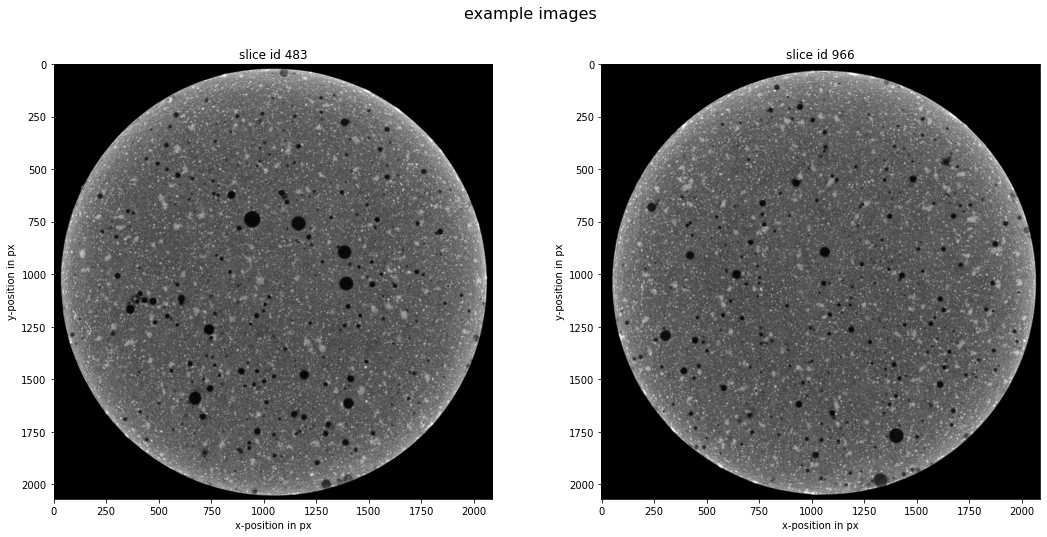

In [3]:
CT.show_example_slices()

## process the mthe background for each slice

e:\GIT\CT_edge_hardening_remover\functions.py:16: RuntimeWarning: overflow encountered in power
  return c + d**(d**((x-x0)/b))


slice 0 done


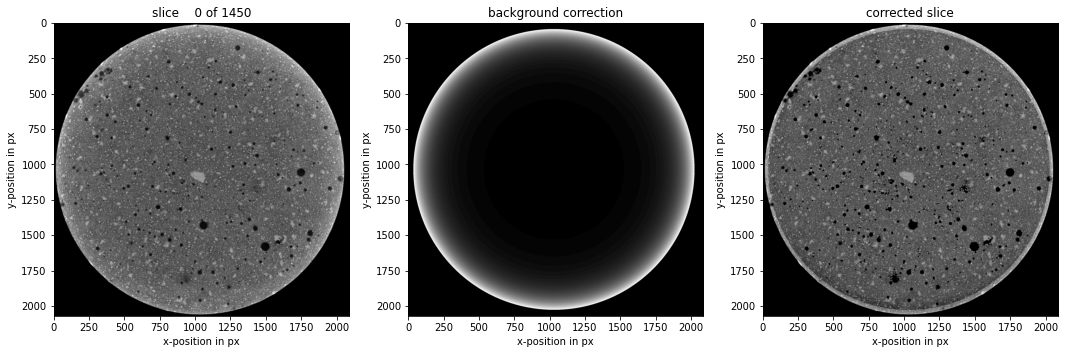

Splitting slice processing in 11 processes.
The processing of each slice may take around 3.6 seconds
The overall process may take 7.8 minutes
slice 50 done
slice 100 done
slice 150 done
slice 200 done
slice 250 done
slice 300 done
slice 350 done
slice 400 done
slice 450 done
slice 500 done
slice 550 done
slice 600 done
slice 650 done
slice 700 done
slice 750 done
slice 800 done
slice 850 done
slice 900 done
slice 950 done
slice 1000 done
slice 1050 done
slice 1100 done
slice 1150 done
slice 1200 done
slice 1250 done
slice 1300 done
slice 1350 done
slice 1400 done


In [5]:
CT.process_full_stack( max_processes = 0, verbose = True )

In [6]:
tifffile.imwrite( save_dir + os.sep + file_name + '_fixed.tif', CT.fixed_volume   )
tifffile.imwrite( save_dir + os.sep + file_name + '_bg.tif',    CT.bg_diff_volume )

In [7]:
"""

time_start = time.time()
for i in range( CT.z ):
	#if i%100 == 0: print("slice{: 5d} of{: 5d}".format(i, CT.z))
	CT.select_slice(i)

	CT.slice.identify_main_circle(verbose=False)
	CT.slice.get_main_circle()
	CT.slice.identify_pores()
	
	circle_max_radii[i]   = CT.slice.min_length    # not really r
	circle_radii[i]   	  = CT.slice.radius    # not really r
	circle_centers[i]     = CT.slice.center
	pore_areas[i]         = CT.slice.pore_area_percent*100

	CT.slice.remove_pores()
	
	fit_data, bg_diff_volume[i], background, fixed_volume[i] = CT.fix_background( iterations= 2, verbose_level = 0 )
	#fixed_volume[i] = (CT.slice - CT.polar_to_circle( CT.fit_to_polar( fit_data, CT.polar_image ) )) * np.logical_not( CT.inner_pores )#CT.remove_pores( background = background_difference )

	if i%50 == 0:
		time_end = time.time()
		print("slice{: 5d} of{: 5d} ({:.1f} s)".format(i, CT.z, time_end-time_start))
		time_start = time_end
	if i%250 == 0:
		fig, ax = plt.subplots(1,3, figsize=(18,6))
		ax[0].imshow( CT.slice, cmap='gray' )
		ax[0].set_title( "slice{: 5d} of{: 5d}".format(i, CT.z) )
		ax[i].imshow( bg_diff_volume[i], cmap='gray' )
		ax[i].set_title( "background correction" )
		ax[i].imshow( fixed_volume[i], cmap='gray' )
		ax[2].set_title( "corrected slice" )
		plt.show()

	
circle_centers = np.swapaxes(circle_centers,0,1)

min_pore_pos = np.argmin(pore_areas)

"""

'\n\ntime_start = time.time()\nfor i in range( CT.z ):\n\t#if i%100 == 0: print("slice{: 5d} of{: 5d}".format(i, CT.z))\n\tCT.select_slice(i)\n\n\tCT.slice.identify_main_circle(verbose=False)\n\tCT.slice.get_main_circle()\n\tCT.slice.identify_pores()\n\t\n\tcircle_max_radii[i]   = CT.slice.min_length    # not really r\n\tcircle_radii[i]   \t  = CT.slice.radius    # not really r\n\tcircle_centers[i]     = CT.slice.center\n\tpore_areas[i]         = CT.slice.pore_area_percent*100\n\n\tCT.slice.remove_pores()\n\t\n\tfit_data, bg_diff_volume[i], background, fixed_volume[i] = CT.fix_background( iterations= 2, verbose_level = 0 )\n\t#fixed_volume[i] = (CT.slice - CT.polar_to_circle( CT.fit_to_polar( fit_data, CT.polar_image ) )) * np.logical_not( CT.inner_pores )#CT.remove_pores( background = background_difference )\n\n\tif i%50 == 0:\n\t\ttime_end = time.time()\n\t\tprint("slice{: 5d} of{: 5d} ({:.1f} s)".format(i, CT.z, time_end-time_start))\n\t\ttime_start = time_end\n\tif i%250 == 0:\n\t\

<ipython-input-8-d2ec310a21ae>:13: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax[i].set_ylim((CT.circle_radii.min()*0.95, CT.circle_radii.max()*1.05))


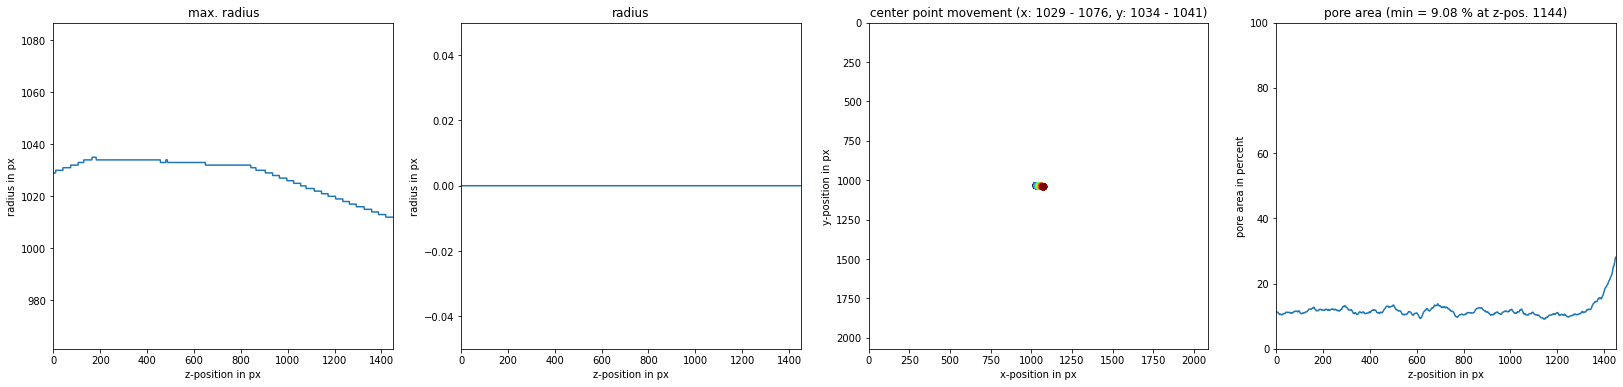

In [8]:
n = 4
fig, ax = plt.subplots(1,n, figsize=(n*7,6))
i = 0 
ax[i].plot( range(CT.z), CT.circle_max_radii )
ax[i].set_xlim((0, CT.z))
ax[i].set_ylim((CT.circle_max_radii.min()*0.95, CT.circle_max_radii.max()*1.05))
ax[i].set_title( "max. radius" )
ax[i].set_xlabel("z-position in {}".format(CT.unit))
ax[i].set_ylabel("radius in {}".format(CT.unit))
i += 1
ax[i].plot( range(CT.z), CT.circle_radii )
ax[i].set_xlim((0, CT.z))
ax[i].set_ylim((CT.circle_radii.min()*0.95, CT.circle_radii.max()*1.05))
ax[i].set_title( "radius" )
ax[i].set_xlabel("z-position in {}".format(CT.unit))
ax[i].set_ylabel("radius in {}".format(CT.unit))
i += 1
ax[i].scatter(CT.circle_centers[0], CT.circle_centers[1], c=range(CT.z), cmap='turbo')
ax[i].set_xlim((0, CT.w))
ax[i].set_ylim((CT.h, 0))
ax[i].set_title( "center point movement (x: {:d} - {:d}, y: {:d} - {:d})".format(CT.circle_centers[0].min(), CT.circle_centers[0].max(), CT.circle_centers[1].min(), CT.circle_centers[1].max()) )
ax[i].set_xlabel("x-position in {}".format(CT.unit))
ax[i].set_ylabel("y-position in {}".format(CT.unit))
i += 1
ax[i].plot( range(CT.z), CT.pore_areas )
ax[i].set_title( "pore area (min = {:.2f} % at z-pos. {:d})".format(CT.pore_areas[CT.min_pore_pos], CT.min_pore_pos) )
ax[i].set_xlim((0, CT.z))
ax[i].set_ylim((0, 100))
ax[i].set_xlabel("z-position in {}".format(CT.unit))
ax[i].set_ylabel("pore area in percent")

plt.show()

In [9]:
raise SystemExit('Stopping execution')

SystemExit: Stopping execution

C:\Users\Florian Kleiner\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# process stack based on a single background fix
- delivers inconsistent results

In [ ]:
CT.select_slice(min_pore_pos)

CT.identify_main_circle(verbose=False)
CT.get_main_circle()

CT.identify_pores()
CT.remove_pores();

found the center point at (954, 956). The circle has a maximum radius of 949 px.


In [ ]:
fit_data, background_difference, background, fixed = CT.fix_background( iterations= 3, verbose_level = 0 )

e:\GIT\CT_edge_hardening_remover\functions.py:16: RuntimeWarning: overflow encountered in power
  return c + d**(d**((x-x0)/b))


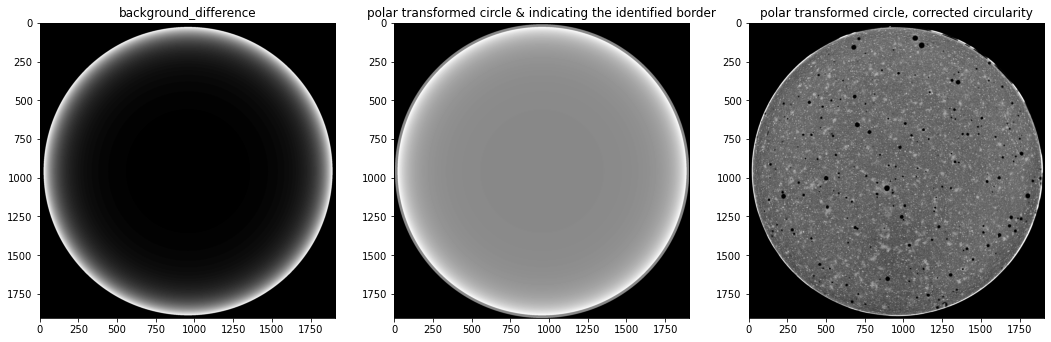

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,6))
ax[0].imshow( background_difference, cmap='gray' )
ax[0].set_title( "background_difference" )
ax[1].imshow( background, cmap='gray' )
ax[1].set_title( "polar transformed circle & indicating the identified border" )
ax[2].imshow( fixed, cmap='gray' )
ax[2].set_title( "polar transformed circle, corrected circularity" )
plt.show()

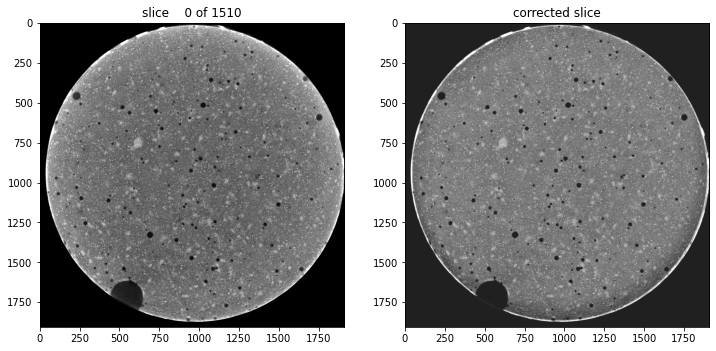

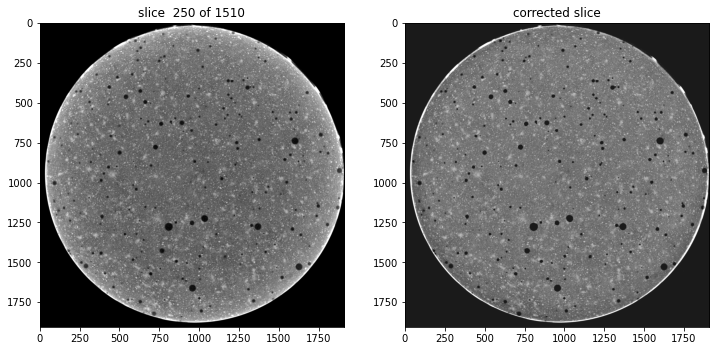

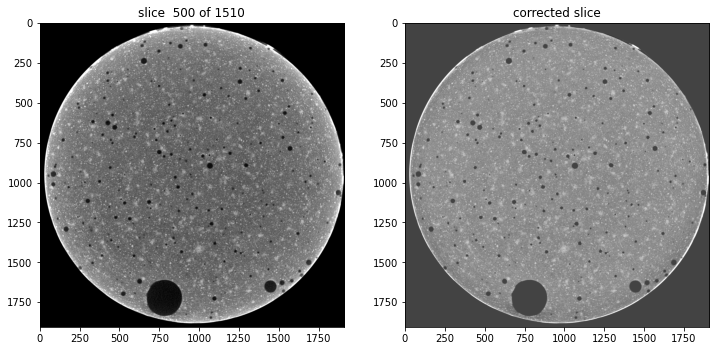

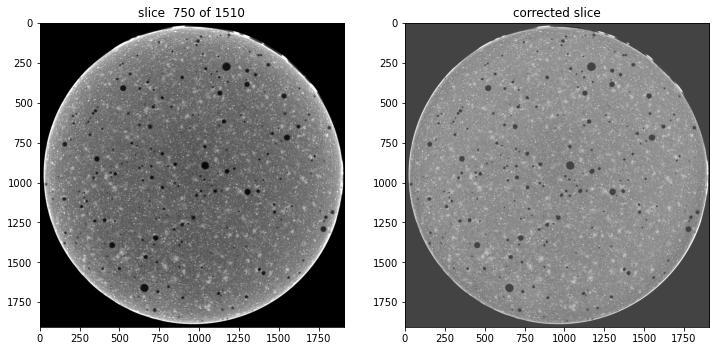

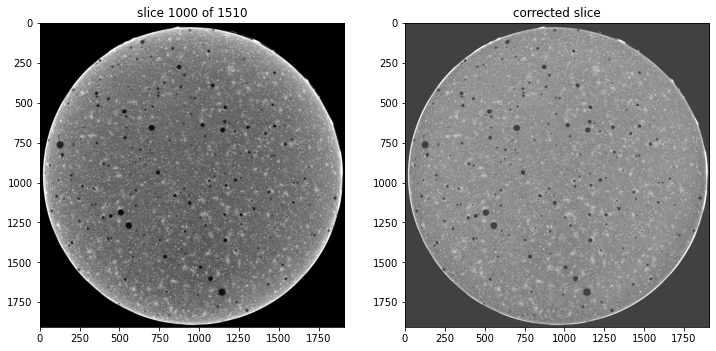

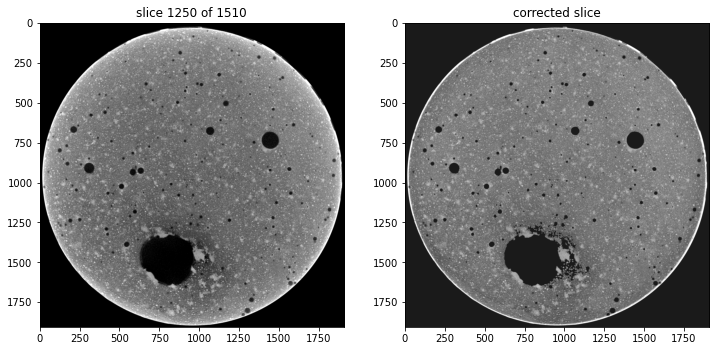

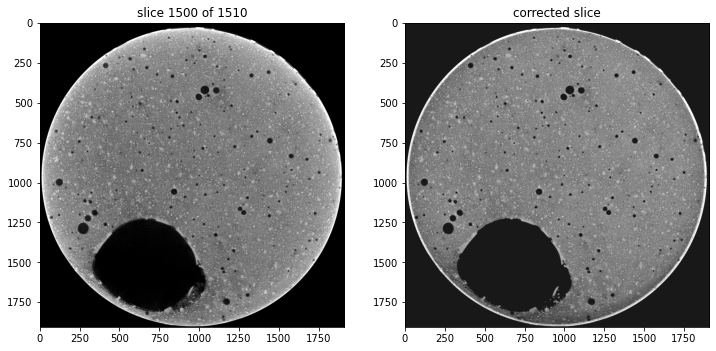

: 

In [ ]:
# polar_background
fixed_volume = np.empty(shape=CT.dataset.shape)
for i in range( CT.z ):
	CT.select_slice(i)
	CT.identify_main_circle(verbose=False)
	CT.get_main_circle()
	CT.identify_pores()
	
	fixed_volume[i] = (CT.slice - CT.polar_to_circle( CT.fit_to_polar( fit_data, CT.polar_image ) )) * np.logical_not( CT.inner_pores )#CT.remove_pores( background = background_difference )

	if i%50 == 0: print("slice{: 5d} of{: 5d}".format(i, CT.z))
	if i%250 == 0:
		fig, ax = plt.subplots(1,2, figsize=(12,6))
		ax[0].imshow( CT.slice, cmap='gray' )
		ax[0].set_title( "slice{: 5d} of{: 5d}".format(i, CT.z) )
		ax[1].imshow( fixed_volume[i], cmap='gray' )
		ax[1].set_title( "corrected slice" )
		plt.show()